In [34]:
#missing values have value ? all for attribute 11

#either edible, poisonous or unknown. Unknowm and poisonous grouped together

#to deal with missing values use 'classifier' or 'regressor' based on values that arent missing to predict missing values in
#preprocessing. Be careful that vlaues using to predict arent overfitted. Compare to other methods such as removing entire attribute
#or giving deafult/mean value

from sklearn import metrics
from sklearn import model_selection
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [13]:
# read contents of data file
file = pd.read_csv("agaricus-lepiota.data")
  
# create list to be used as headers
features = ['edibility', 'capShape', 'capSurface', 'capColor', 'bruises', 'odor', 
            'gillAttachment', 'gillSpacing', 'gillSize', 'gillColor', 
            'stalkShape', 'stalkRoot', 'stalkSurfaceAboveRing', 'stalkSurfaceBelowRing', 
            'stalkColorAboveRing', 'stalkColorBelowRing', 'veilType', 'veilColor', 
            'ringNumber', 'ringType', 'sporePrintColor', 'population', 'habitat']

#convert '?' to NaN
file.replace({'?': np.nan}, inplace=True)

# converting data frame to csv
file.to_csv("agaricus-lepiota.csv", header=features, index=False)

data = pd.read_csv("agaricus-lepiota.csv")

#result = data.head(10)
#print(data)
#print(result)

In [99]:
#removes column with missing values which in our data is only stalkRoot
#one way to deal with missing values
print(data.shape)

data = data.drop('stalkRoot', axis = 1)

print(data.shape)

data.to_csv("agaricus-lepiota-no-stalkRoot.csv")

#print(data.head(10))

(8123, 23)
(8123, 22)


In [101]:
#removes all rows that have missing values
print(data.shape)

data = data.dropna(axis = 0).reset_index(drop=True)
 
#shows we lose alot of data as 2480 rows lost
#bad way of handling missing values
print(data.shape)

data.to_csv("agaricus-lepiota-NaN-removed.csv")

(8123, 23)
(5643, 23)


In [14]:
#use label encoding on all featres that are categorical
#OneHot encoding not applicable as there are a high number of categories
le = LabelEncoder()

data['edibility'] = le.fit_transform(data['edibility'])
data['capShape'] = le.fit_transform(data['capShape'])
data['capSurface'] = le.fit_transform(data['capSurface'])
data['capColor'] = le.fit_transform(data['capColor'])
data['bruises'] = le.fit_transform(data['bruises'])
data['odor'] = le.fit_transform(data['odor'])
data['gillAttachment'] = le.fit_transform(data['gillAttachment'])
data['gillSpacing'] = le.fit_transform(data['gillSpacing'])
data['gillSize'] = le.fit_transform(data['gillSize'])
data['gillColor'] = le.fit_transform(data['gillColor'])
data['stalkShape'] = le.fit_transform(data['stalkShape'])
data['stalkRoot'] = le.fit_transform(data['stalkRoot'])
data['stalkSurfaceAboveRing'] = le.fit_transform(data['stalkSurfaceAboveRing'])
data['stalkSurfaceBelowRing'] = le.fit_transform(data['stalkSurfaceBelowRing'])
data['stalkColorAboveRing'] = le.fit_transform(data['stalkColorAboveRing'])
data['stalkColorBelowRing'] = le.fit_transform(data['stalkColorBelowRing'])
data['veilType'] = le.fit_transform(data['veilType'])
data['veilColor'] = le.fit_transform(data['veilColor'])
data['ringNumber'] = le.fit_transform(data['ringNumber'])
data['ringType'] = le.fit_transform(data['ringType'])
data['sporePrintColor'] = le.fit_transform(data['sporePrintColor'])
data['population'] = le.fit_transform(data['population'])
data['habitat'] = le.fit_transform(data['habitat'])

data.to_csv("agaricus-lepiota-encoded.csv")

In [61]:
#predict missing values for stalkRoot
train_data = data[data['stalkRoot']!= 4].copy()
test_data = data[data['stalkRoot'] == 4].copy()

X_train = train_data.drop('stalkRoot', axis = 1)
y_train = train_data['stalkRoot']

X_test = test_data.drop('stalkRoot', axis = 1)

rfc = RandomForestRegressor()

rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

rounded_data = (np.rint(y_pred)).astype(int)
test_data['stalkRoot'] = rounded_data

test_data.to_csv("predicted-missing-values.csv")

frames = [train_data, test_data]
treated_data = pd.concat(frames)

X = treated_data.drop('edibility', axis = 1)
y = treated_data['edibility']

data_scaled = StandardScaler().fit_transform(X)

treated_data.to_csv("full-data.csv")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


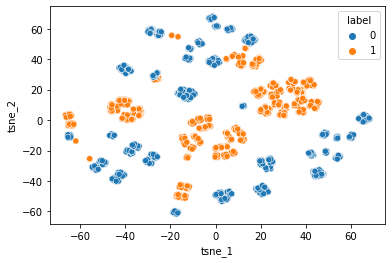

In [73]:
#data visualisation t-sne
#unlike pca its not linear so much more complex and better for our data I think
#result of t-sne greatly affected by 'perplexity' hyperparameter
#try perplexity values in the range 5-100 default is 30. Higher perplexity takes longer
n_components = 2
tsne = TSNE(n_components, perplexity=100)
tsne_features = tsne.fit_transform(data_scaled)

tsne_df = pd.DataFrame({'tsne_1': tsne_features[:,0], 'tsne_2': tsne_features[:,1], 'label': treated_data['edibility']})

sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'label', data = tsne_df)

plt.show()

[19.  12.3 10.7 10.   8.1  6.7  4.7  4.5  3.8  3.6  2.9  2.7  2.4  2.1
  1.9  1.4  1.1  0.7  0.6  0.4  0.3  0. ]


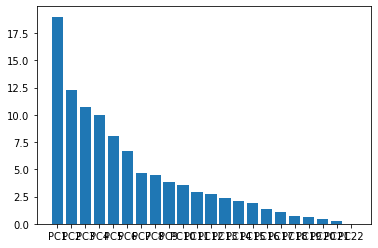

         pca_1     pca_2  label
0    -1.695511 -0.380972      0
1    -1.256226 -0.969427      0
2     0.188353 -1.535155      1
3     1.979517 -0.242445      0
4    -1.868758 -0.457702      0
...        ...       ...    ...
8118 -2.022424 -0.489409      0
8119 -3.189688 -0.398053      0
8120 -1.442855 -0.246081      0
8121  3.684614 -0.853562      1
8122 -1.418134 -0.762595      0

[8123 rows x 3 columns]


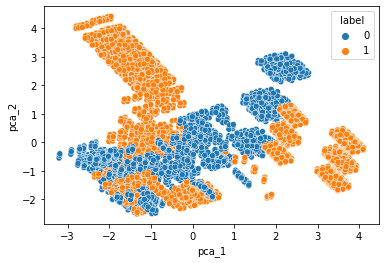

In [72]:
#data visualisation pca
#a linear method so less complex than tsne thus takes much less time
#not very useful for our dataset I dont think as shown by the explained variance and scree plot
pca = PCA()
pca_features = pca.fit_transform(data_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(per_var)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

#to be seen on a 2D-plot we can only use PC1 and PC2 which gives us the highest explained variance but still very low
#around 19% + 12% = 31% explained variance which is bad
plt.bar(x= range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.show()

pca_df = pd.DataFrame({'pca_1': pca_features[:,0], 'pca_2': pca_features[:,1], 'label': treated_data['edibility']})
print(pca_df)

sns.scatterplot(x = 'pca_1', y = 'pca_2', hue = 'label', data = pca_df)

plt.show()